# Questions

- ED formula: isn't there a missing sign compared to (144) (what about the $()^2$ ?)

# TODO

- Impose bath energy symmetry
- Look at Mott transition

DMFT on finite lattice represents better infinite lattice that just Hubbard on finite lattice.

Quantum Lanczos article: https://arxiv.org/pdf/2105.13298.pdf

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from scipy.optimize import minimize
from scipy.signal import argrelmin
from time import time

In [8]:
T = 0.05
beta = 1/T

# The discretized values of omega
omega = np.linspace(-10, 10, 100000, dtype = complex)

# The Matsubara frequencies
max_freq = 100
n_freq = int(((max_freq * beta / np.pi) - 1) / 2) + 1
matsu_freq = (2 * np.array(range(-n_freq, n_freq), dtype = complex) + 1) * np.pi / beta

# The small delta
delta = 1e-3

In [9]:
# Plots complex array by showing real and imaginary parts
# Supports both single array and lists of arrays
def plot_complex(a, title, is_matsu = True, labels = None, show_inv = False, xlim = None):
    
    fig, ax = plt.subplots(1,2, figsize = (12,5))
    fig.suptitle(title)
    
    if is_matsu:
        y = matsu_freq
    else:
        y = omega
    
    if not type(a[0]) == np.complex128:
        arr = a
        if labels == None:
            labelss = [None] * len(arr)
        else:
            labelss = labels
    else:
        arr = [a]
        labelss = [labels]
        
    for k,f in enumerate(arr):
        ax[0].plot(np.real(y), np.real(f), label = labelss[k])
        ax[1].plot(np.real(y), np.imag(f), label = labelss[k])
        if show_inv:
            ax[1].plot(np.real(matsu_freq), - 1 / np.real(matsu_freq))
            ax[1].set_ylim(np.min(np.imag(np.array(arr))), np.max(np.imag(np.array(arr))))
        
        if xlim != None:
            ax[1].set_xlim(xlim)

    ax[0].set_title("Real Part")
    ax[1].set_title("Imaginary Part")
    if labels != None:
        plt.legend()

We retrieve the parameters $\{V_k, \epsilon_k\}_k$ of the Anderson impurity model from the hybridization function:

$$\Delta(\omega) = \sum_k \frac{V_k^2}{\omega - \epsilon_k + i\delta}$$

We place ourselves at half-filling so that $\mu = \frac U2$, and the AIM hamiltonian reads:

$$H = U n_\uparrow n_\downarrow - \frac U 2 (n_\uparrow + n_\downarrow) + \sum_{k,\sigma} \epsilon_k a_{k,\sigma}^\dagger a_{k,\sigma} + \sum_{k,\sigma} V_k (a_{k,\sigma}^\dagger c_\sigma + c_\sigma^\dagger a_{k,\sigma})$$

where $a_{k,\sigma}^\dagger$ denotes the creation operator of an electron in the bath, $c_\sigma^\dagger$ denotes the creation operator of the impurity electron and $n_\sigma = c_\sigma^\dagger c_\sigma$.

### Retrieval of the hamiltonian parameters

$\Delta(\omega)$ is represented as an array of complex numbers corresponding to different values of $\omega$. We recover the hamiltonian parameters $\{V_k, \epsilon_k\}_k$ by optimizing a function:

$$f : \{V_k, \epsilon_k\}_k \to \Delta(\omega) $$

against the real $\Delta(\omega)$.

To obtain an initial guess, we use the fact that the local minima of $\Im (\Delta(\omega))$ are the $\epsilon_k$ and that close to $\epsilon_k$, its contribution will dominate so that:

$$V_k^2 \approx - \delta \Im (\Delta(\epsilon_k))$$

In [244]:
# Retrieval of hamiltonian parameters from the hybridization function with Matsubara frequencies

def matsuHybridizationFunction(V, e):
    n = len(V)
    s = matsu_freq * 0
    for k in range(n):
        s += V[k]**2 / (1.j * matsu_freq - e[k])
    return s

def matsuHamParameters(matsu_hyb_func, n_k):
    
    # The format of the argument of matsu_optimize_me is V_i, e_i
    def matsu_optimize_me(args, parity):
        n = len(args)
        
        if parity == 0:
            V = args[:2 * n // 3]
            e = args[2 * n // 3:]
        else:
            V = args[:(2 * n - 1) // 3]
            e = args[(2 * n - 1) // 3:]
        #TODO
        return np.linalg.norm(matsu_hyb_func - matsuHybridizationFunction(V, e)) ** 2
    
    parity = n_k % 2
    if parity == 0:
        args_ini = np.zeros(n_k + n_k // 2)
    else:
        args_ini = np.zeros(n_k + (n_k - 1) // 2)
    
    # minimize matsu_optimize_me
    res = minimize(matsu_optimize_me, args_ini, args = parity, method = 'Powell', tol = 1e-10)
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [ ]:
3/2 nk - 1/2 = n
nk = 1/3 (2n - 1 )

In [245]:
# Check that it works properly

n_k = 3
V = [3.6, 2.3, 1.2]
e = [-2.1, 1.1, 0.4]

matsu_hyb_func = matsuHybridizationFunction(V, e)
matsuHamParameters(matsu_hyb_func, n_k)

(array([ 3.6,  1.2, -2.3]), array([-2.1,  0.4,  1.1]), 4.669977321149528e-21)

# Constructing the hamiltonian

Using the hamiltonian parameters $\{V_k, \epsilon_k\}_k$, we can now construct the hamiltonian. We use the following convention indexing the sites with $i$:
- If $i$ is even, the site has spin up
- If $i$ is odd, the site has spin down
- $i//2 = 0$ indicates the impurity site
- $i//2 = k > 0$ indicates site k - 1

For example 100100 indicates that the spin up impurity site and the spin down first bath level are filled.

Creation operator are ordered with the smallest index on the left:

$$ |100100\rangle = a_\uparrow^\dagger c_{1, \downarrow}^\dagger |000000\rangle = c_1^\dagger c_4^\dagger |000000\rangle$$

### Change sign with ordering of operator

With fermionic system, a state is defined with a conventional ordering of fermionic operators. For example:

$$ | 1001 \rangle = c_1^\dagger c_4^\dagger | 0 \rangle = - c_4^\dagger c_1^\dagger | 0 \rangle $$
$$ | 1110 \rangle = c_1^\dagger c_2^\dagger c_3^\dagger | 0 \rangle $$

The Hamiltonian should reflect this because `create` and `destroy` do not have the good anticommutation relations.

Defining $c_k^\dagger = \bigotimes_{j < k} \sigma_j^z \otimes \sigma_k^+$ ensures the correct anticommutation relations.

In [12]:
def AIM(V, e, U):
    
    # Number of sites in the bath
    nk = len(V)
    
    # Total number of sites
    n = 2 * (nk + 1)
    
    # Defines the fermionic creation operators
    cdags = []
    for k in range(n):
        prod = [sigmaz() for x in range(k)] + [create(2)] + [qeye(2) for x in range(n - k - 1)]
        cdags.append(tensor(prod))
    
    # Impurity on-site interaction
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    prod[1] = num(2)
    H1 = U * tensor(prod)
    
    # Impurity chemical potential
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    H2 = - (U/2) * tensor(prod)
    prod = [qeye(2) for x in range(n)]
    prod[1] = num(2)
    H2 += - (U/2) * tensor(prod)
    
    # Bath energy levels
    H3 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            prod = [qeye(2) for x in range(n)]
            prod[2*(k + 1) + spin] = num(2)
            H3 += e[k] * tensor(prod)
    
    # Bath-impurity interaction
    H4 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            
            H4 += V[k] * cdags[2*(k + 1) + spin] * cdags[spin].dag()
            
            H4 += V[k] * cdags[spin] * cdags[2*(k + 1) + spin].dag()
            
    return H1 + H2 + H3 + H4

##### An example to check that the hamiltonian is correct

In [13]:
H = AIM([2, 2], [3, -3], 1)
H

Quantum object: dims = [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0. -3.  0. ...  0.  0.  0.]
 [ 0.  0. -3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  3.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

In [14]:
H[int('100000', 2), int('100000', 2)]

(-0.5+0j)

# Impurity Green's function

We compute the diagonal element of the Green's function corresponding to the impurity spin up site in frequency space.

$$ G(\omega) = \frac{1}{Z} \sum_{n,n'} \frac{|\langle n' | c_\uparrow^\dagger | n \rangle|^2}{\omega + E_n - E_{n'} + i\delta} \left( e^{-\beta E_n} + e^{-\beta E_{n'}} \right) $$

$$ G(i \omega_k) = \frac{1}{Z} \sum_{n,n'} \frac{|\langle n' | c_\uparrow^\dagger | n \rangle|^2}{i \omega_k + E_n - E_{n'}} \left( e^{-\beta E_n} + e^{-\beta E_{n'}} \right) $$

In [15]:
# Returns the spin up impurity green's function given the hamiltonian

def impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # We set the ground energy to 0 to avoid problems in the exponential
    eigvals = eigvals - eigvals[0]
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0
            
            prob = abs((ei.H @ ej)[0,0])**2
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (omega + eigvals[j] - eigvals[i] + 1.j * delta)
    
    return G / Z

In [16]:
# Returns the spin up impurity green's function with Matsubara frequencies given the hamiltonian

def matsu_impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # We set the ground energy to 0 to avoid problems in the exponential
    eigvals = eigvals - eigvals[0]
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            # No anticommutation problem because we consider the first site
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0                
            
            prob = abs((ei.H @ ej)[0,0])**2
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])
    
    return G / Z

# Computing Green's function with the Lanczos algorithm

- Approximate the eigendecomposition
- Obtain the Lanczos coefficients starting from the ground state

In [125]:
# Performs Gram-Schmidt reorthogonalization

def GramSchmidt(lx):
    ly = []
    for i,x in enumerate(lx):
        y = x
        for j in range(i):
            y += - (x.dag() * ly[j]).tr() * ly[j]
        ly.append(y / y.norm())
    return ly

In [124]:
# Performs m iteration of the Lanczos algorithm on H with initial vector x
# Now supports stable spaces

def Lanczos(H, x, m, reortho = 0):
    
    lx = [0 * x, x]
    a = []
    b = [0]
    
    for k in range(m - 1):
        
        y = H * lx[-1]
        a.append((lx[-1].dag() * y).tr())
        y = y - a[-1] * lx[-1] - b[-1] * lx[-2]
        b.append(y.norm())

        # Removes the first vector 0 once it is no longer needed
        if k == 0:
            del lx[0]
        
        # If the new b is too small, it means we have found an invariant subspace and the current y could not be
        # made orthogonal to the others.
        # In that case we take a new random unit vector that we orthogonalize to the others
        if b[-1] < 1e-9:
            #b[-1] = 0
            new_x = Qobj(np.random.rand(x.shape[0]))
            new_x = new_x / new_x.norm()
            lx.append(new_x)
            
            try:
                lx = GramSchmidt(lx)
            except:
                raise ZeroDivisionError
            
        else:
            lx.append(y / b[-1])
        
        # Reorthogonalize
        for _ in range(reortho):
            try:
                lx = GramSchmidt(lx)
            except:
                raise ZeroDivisionError

    y = H * lx[-1]
    a.append((lx[-1].dag() * y).tr())
    
    """
    for i,x in enumerate(lx):
        for j in range(i):
            sp = (x.dag() * lx[j]).tr()
            if sp > 1e-5:
                print('not ortho')
    """
    
    return lx, a, b

In [126]:
# Recompose the matrices T and U from the output of Lanczos such that H = U * T * U^dag

def Lanczos_recompose(lx, a, b):
    
    m = len(a)
    n = lx[0].shape[0]
    
    T = np.zeros((m,m), dtype = complex)
    U = np.zeros((n,m), dtype = complex)

    for k in range(m - 1):
        T[k,k] = a[k]
        T[k, k + 1] = b[k + 1]
        T[k + 1, k] = b[k + 1]
    T[-1, -1] = a[-1]

    for k in range(m):
        U[:,k] = np.array(lx[k]).flatten()

    return Qobj(T), Qobj(U)

In [129]:
# A test with one bath site

M = AIM([4], [2], 1)
M.dims = [[16],[16]]
lnorm = []
lgs = []

for _ in range(10):
    x0 = Qobj(np.random.rand(16))
    x0 = x0 / x0.norm()

    lx, a, b = Lanczos(M, x0, 16, reortho = 0)

    Tm, U = Lanczos_recompose(lx, a, b)

    Teigs, Tvecs = np.linalg.eigh(Tm._data.todense())
    Meigs, Mvecs = np.linalg.eigh(M._data.todense())
    
    TGS = U * Qobj(Tvecs[:,0])
    GS = Qobj(Mvecs[:,0])
    
    lnorm.append((M - U * Tm * U.dag()).norm())
    lgs.append(min((TGS - GS).norm(), (TGS + GS).norm()))

#print(Teigs)
#print(Meigs)

### Impurity Green's function as a sum of continuous fractions

If we neglect the contribution from non-ground states, the impurity Green's function reads:

$$ G(z) = ||c^\dagger | \text{GS} \rangle ||^2 g_{\phi^+}(z + E_0) - ||c | \text{GS} \rangle ||^2 g_{\phi^-}(-z + E_0)$$

with $\phi^+ = \frac{c^\dagger | \text{GS} \rangle}{||c^\dagger | \text{GS} \rangle ||}$ and $\phi^- = \frac{c | \text{GS} \rangle}{||c | \text{GS} \rangle ||}$ and following the definition:

$$ g_\phi(z) = \langle \phi | (z - H)^{-1} | \phi \rangle $$

Upon obtaining the Lanczos decomposition, we can express $g_\phi(z)$ as a continuous fraction:

$$ g_\phi(z) = \frac{1}{z - a_0 - \frac{b_1^2}{z - a_1 - \frac{b_2^2}{...}}} $$

In [132]:
# Constructs the continuous fraction from the Lanczos decomposition

def cont_frac(z, a, b):
    n = len(a)
    g = 1 / (z - a[n - 1])
    for k in range(n - 2, -1, -1):
        g = 1 / (z - a[k] - (b[k + 1]**2 * g))
    return g

In [133]:
# Returns the spin up impurity green's function given the hamiltonian using the Lanczos algorithm

# m1 is the number of Lanczos iteration for the first step and m2 for the second

def Lanczos_green_full(H, T, state_num, m1, m2, reortho, seed):
        
    # Compute the state_num first states
    n = H.shape[0]
    H.dims = [[n],[n]]
    
    if seed != -1:
        np.random.seed(seed)
    
    x0 = Qobj(np.random.rand(n))
    x0 = x0 / x0.norm()
    
    lx, a, b = Lanczos(H, x0, m1, reortho = reortho)
    Tm, U = Lanczos_recompose(lx, a, b)
    Teigs, Tvecs = np.linalg.eigh(Tm._data.todense())
    
    state_list = []
    energy_list = []
    for k in range(state_num):
        state = U * Qobj(Tvecs[:,k])
        state = state / state.norm()
        E = (state.dag() * H * state).tr()
        state_list.append(state)
        energy_list.append(E)
    
    energy_list = np.array(energy_list)

    # We set the ground energy to 0 to avoid problems in the exponential
    E0 = energy_list[0]
    energy_list = energy_list - E0
    H = H - E0
    
    Z = np.sum(np.exp(- energy_list / T))

    G = 0

    for k, psi in enumerate(state_list):

        Ek = energy_list[k]
        
        # Lanczos with c^dag psi
        cdag = tensor([create(2)] + [qeye(2) for _ in range(int(np.log2(n) - 1))])
        cdag.dims = [[n],[n]]
        phi_p = cdag * psi
        phi_p_norm = phi_p.norm()
        if phi_p_norm == 0:
            g_p = 0
        else:
            phi_p = phi_p / phi_p_norm

            try:
                lx_p, a_p, b_p = Lanczos(H, phi_p, m2, reortho = reortho)
            except ZeroDivisionError:
                raise ZeroDivisionError('Lanczos Failed')
            
            # Construct the continuous fraction +
            g_p = cont_frac(1.j * matsu_freq + Ek, a_p, b_p)
        
        # Lanczos with c psi
        phi_m = cdag.dag() * psi
        phi_m_norm = phi_m.norm()
        if phi_m_norm == 0:
            g_m = 0
            
        else:
            phi_m = phi_m / phi_m_norm

            try:
                lx_m, a_m, b_m = Lanczos(H, phi_m, m2, reortho = reortho)
            except ZeroDivisionError:
                print("\n\n\nFailed on plus")
                print("k: " + str(k))
                raise ZeroDivisionError('Lanczos Failed')
            
            # Construct the continuous fraction -
            g_m = cont_frac(- 1.j * matsu_freq + Ek, a_m, b_m)

        G += np.exp(-Ek / T) * (phi_p_norm**2 * g_p - phi_m_norm**2 * g_m)

    return G / Z

# DMFT loop

We work on the Bethe lattice for a simplified loop: $\Delta(\omega) = t^2 G_\text{imp}$

In [134]:
# Returns the spin up impurity green's function given the hybridization function

def matsu_loopstep(matsu_hyb_func, n_k, U, T, lanczos = False, num_states = 1, m = 10, return_real = True, reortho = 0, seed = -1, verbose = False):
    
    if verbose:
        print("Retrieving hamiltonian parameters")
    
    V, e, val = matsuHamParameters(matsu_hyb_func, n_k)

    if verbose:    
        print("Optimization MSE: {:.4}".format(val))
        print(V)
        print(e)
    
    H = AIM(V, e, U)
    
    if verbose:
        print("Computing green's function\n")
    
    if lanczos:
        G = Lanczos_green_full(H, T, num_states, m, m, reortho, seed)
    else:
        G = matsu_impurity_green(H, T)
    
    if return_real:
        realG = impurity_green(H, T)
        return G, realG
    else:
        return G

### Initial Green's function

We start with a circular spectral function:

$$G_\text{ini}(\omega) = \frac{\omega - \text{sgn}(\omega)\sqrt{\omega^2 - 4t^2}}{2t^2}$$
or $$G_\text{ini}(i\omega_n) = \frac{i\omega_n - \text{sgn}(\omega_n)i\sqrt{\omega_n^2 + 4t^2}}{2t^2}$$

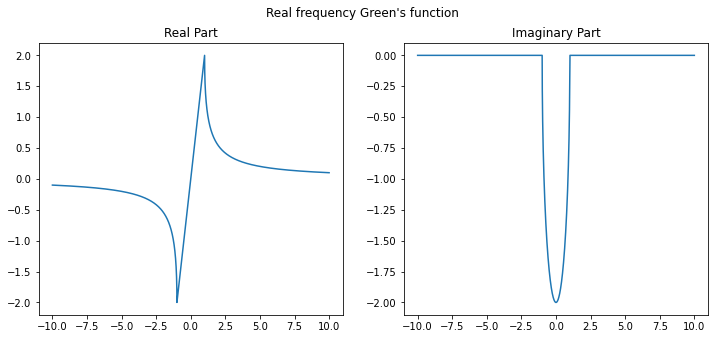

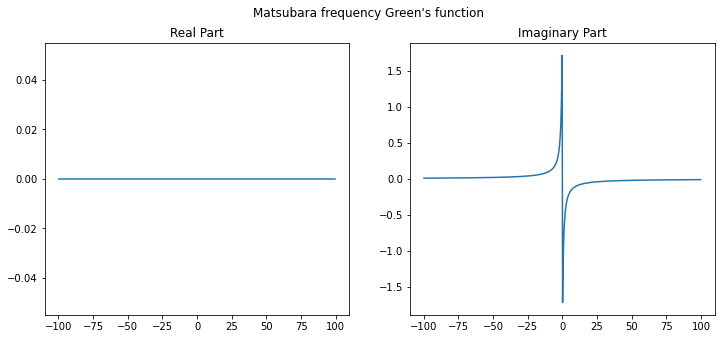

In [135]:
t = 0.5

hyb_func = (omega - np.sign(np.real(omega)) * (omega ** 2 - 4 * t ** 2) ** 0.5) / (2 * t ** 2)
plot_complex(hyb_func, "Real frequency Green's function", is_matsu = False)

matsu_hyb_func = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 4 * t ** 2) ** 0.5) / (2 * t ** 2)
plot_complex(matsu_hyb_func, "Matsubara frequency Green's function", is_matsu = True)

Step 1
Retrieving hamiltonian parameters
Optimization MSE: 3.882
[-0.59850551]
[-1.8133288e-10]
Computing green's function

Time of ED:      0.047
Time of Lanczos: 0.0

Done


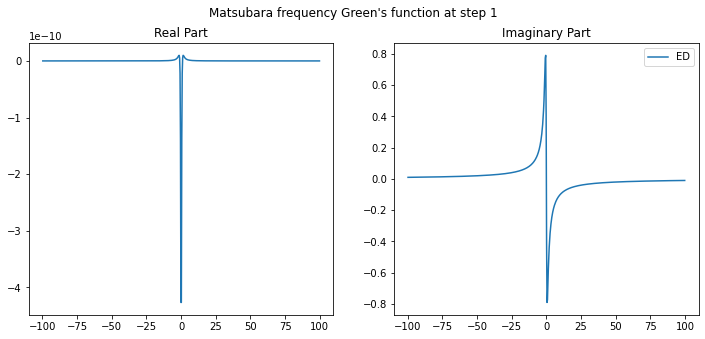

In [176]:
# T was defined above
n_k = 1
U = 1

seed = 1

xlim = (-20,20)
xlim = None

t = 0.5
matsu_hyb_func = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 4 * t ** 2) ** 0.5) / (2 * t ** 2)

matsu_hyb_func_list = [matsu_hyb_func.copy() for _ in range(1)]
labels = ["ED", "$m = 16, k = 16$"]

for k in range(1):
    
    print("Step {}".format(k + 1))
    
    t0 = time()
    matsu_hyb_func_list[0] = matsu_loopstep(matsu_hyb_func_list[0], n_k, U, T, return_real = False, verbose = True)
    t1 = time()
    #matsu_hyb_func_list[1] = matsu_loopstep(matsu_hyb_func_list[1], n_k, U, T, lanczos = True, num_states = 16, m = 16, reortho = 1, return_real = False, seed = seed, verbose = True)
    
    #print("Real error of Lanczos:      {:.3}".format(max(abs(np.real(matsu_hyb_func_list[1] - matsu_hyb_func_list[0])))))
    #print("Imaginary error of Lanczos: {:.3}".format(max(abs(np.imag(matsu_hyb_func_list[1] - matsu_hyb_func_list[0])))))
    #print()
    print("Time of ED:      {:.3}".format(t1 - t0))
    print("Time of Lanczos: {:.3}".format(time() - t1))
    print()
    
    plot_complex(matsu_hyb_func_list, "Matsubara frequency Green's function at step " + str(k + 1), is_matsu = True, show_inv = False, labels = labels, xlim = xlim)

print("Done")

# Mott Transition

We perform DMFT loop and try to observe a Mott transition. A fixed $T$, we look at the shape of the stable imaginary part for different values of $U$. If the extrapolated value at 0 is 0 then we have an insulator, otherwise we have a conductor.

Step 1
Difference from last GF: 1.302

Step 2
Difference from last GF: 1.307

Step 3
Difference from last GF: 1.801

Step 4
Difference from last GF: 1.569

Step 5
Difference from last GF: 1.677

Step 6
Difference from last GF: 1.551

Step 7
Difference from last GF: 1.617

Step 8
Difference from last GF: 1.549

Step 9
Difference from last GF: 1.591

Step 10
Difference from last GF: 1.552



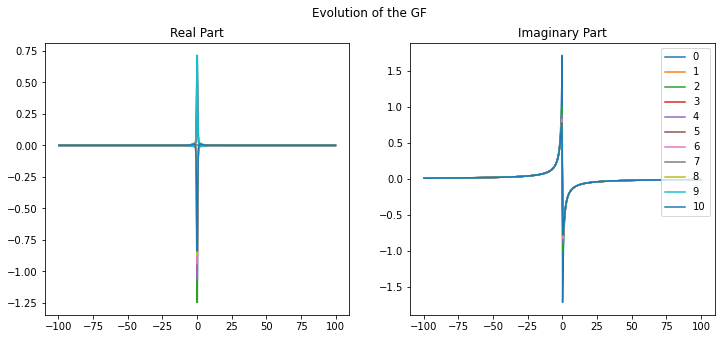

In [246]:
# T was defined above
n_k = 1
U = 1

nstep = 10

conv_eps = 1e-3

seed = 1

xlim = None

t = 0.5
GF_ini = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 4 * t ** 2) ** 0.5) / (2 * t ** 2)

GF_time_list = [GF_ini.copy()]

for k in range(nstep):
    
    print("Step {}".format(k + 1))
    
    GF_time_list.append(matsu_loopstep(GF_time_list[-1], n_k, U, T, return_real = False))
    print("Difference from last GF: {:.4}".format(max(abs(GF_time_list[-1] - GF_time_list[-2]))))
    print()

plot_complex(GF_time_list, "Evolution of the GF", is_matsu = True, labels = list(range(nstep + 1)), xlim = xlim)

# Questions

- Formula $(8)$
- Energy shift in $g_\phi$

### Random notes

$$ G(i\omega_n) = G^*(-i\omega_n) $$

Matsubara Green's function should have symmetric real part and antisymmetric imaginary part. Retarded Green's function should be the opposite: antisymmetric real part and symmetric imaginary part.

The extrapolation at 0 of the imaginary part of $G(i\omega_n)$ should be $A(0)$ (The value at 0 of the corresponding spectral function).

The imaginary part of $G(i\omega_n)$ should decay as $1/\omega_n$.

Real frequency GF should have symmetric peak